In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import datetime
from sklearn import datasets
import pandas_datareader as web
from pandas_datareader import data
from pandas.io.formats.style_render import DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, LSTM, Bidirectional
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')


In [3]:
from google.colab import files
dataset = files.upload()

Saving ADANIPORTS.csv to ADANIPORTS.csv


In [5]:
gstock_data = pd.read_csv('ADANIPORTS.csv')
gstock_data .head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619,0.3612
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278,0.3172
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678,0.2088
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913,0.2735
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123,0.2741


In [6]:
gstock_data.shape

(3322, 15)

In [7]:
gstock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                3322 non-null   object 
 1   Symbol              3322 non-null   object 
 2   Series              3322 non-null   object 
 3   Prev Close          3322 non-null   float64
 4   Open                3322 non-null   float64
 5   High                3322 non-null   float64
 6   Low                 3322 non-null   float64
 7   Last                3322 non-null   float64
 8   Close               3322 non-null   float64
 9   VWAP                3322 non-null   float64
 10  Volume              3322 non-null   int64  
 11  Turnover            3322 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  3322 non-null   int64  
 14  %Deliverble         3322 non-null   float64
dtypes: float64(10), int64(2), object(3)
memory usage: 389.4

In [8]:
gstock_data = gstock_data[['Date','Open','Close']] # Extracting required columns
gstock_data['Date'] = pd.to_datetime(gstock_data['Date'].apply(lambda x: x.split()[0])) # Selecting only date
gstock_data.set_index('Date',drop=True,inplace=True) # Setting date column as index
gstock_data.head()

<ipython-input-8-159522c21f0a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gstock_data['Date'] = pd.to_datetime(gstock_data['Date'].apply(lambda x: x.split()[0])) # Selecting only date


,Open,Close
Date,,
2007-11-27,770.00,962.90
2007-11-28,984.00,893.90
2007-11-29,909.00,884.20
2007-11-30,890.00,921.55
2007-12-03,939.75,969.30


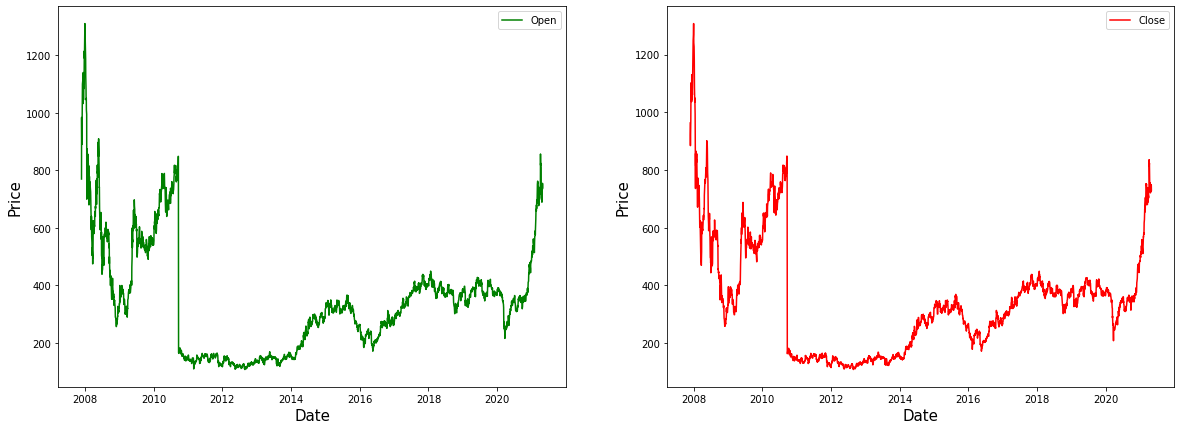

In [9]:
fg, ax =plt.subplots(1,2,figsize=(20,7))
ax[0].plot(gstock_data ['Open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()
ax[1].plot(gstock_data ['Close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()
fg.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
gstock_data[gstock_data.columns] = MMS.fit_transform(gstock_data)

In [11]:
# Selecting 80 % for training and 20 % for testing
training_size = round(len(gstock_data ) * 0.80)
training_size

2658

In [12]:
train_data = gstock_data [:training_size]
test_data  = gstock_data [training_size:]
train_data.shape, test_data.shape

((2658, 2), (664, 2))

In [13]:
# Function to create sequence of data for training and testing
def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)): # Selecting 50 rows at a time
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

In [14]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [15]:
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((2608, 50, 2), (2608, 2), (614, 50, 2), (614, 2))

In [16]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=50))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 30,902
Trainable params: 30,902
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/80
82/82 [==============================] - 7s 45ms/step - loss: 0.0036 - mean_absolute_error: 0.0315 - val_loss: 4.4565e-04 - val_mean_absolute_error: 0.0158
Epoch 2/80
82/82 [==============================] - 3s 36ms/step - loss: 0.0011 - mean_absolute_error: 0.0168 - val_loss: 3.4218e-04 - val_mean_absolute_error: 0.0129
Epoch 3/80
82/82 [==============================] - 3s 36ms/step - loss: 8.5627e-04 - mean_absolute_error: 0.0149 - val_loss: 3.2837e-04 - val_mean_absolute_error: 0.0133
Epoch 4/80
82/82 [==============================] - 3s 36ms/step - loss: 7.5722e-04 - mean_absolute_error: 0.0140 - val_loss: 2.8675e-04 - val_mean_absolute_error: 0.0121
Epoch 5/80
82/82 [==============================] - 3s 36ms/step - loss: 6.8698e-04 - mean_absolute_error: 0.0132 - val_loss: 4.3990e-04 - val_mean_absolute_error: 0.0171
Epoch 6/80
82/82 [==============================] - 3s 35ms/step - loss: 6.5446e-04 - mean_absolute_error: 0.0134 - val_loss: 2.3873e-04 - val_mean_absol

In [18]:
test_predicted = model.predict(test_seq)
test_predicted[:20]

20/20 [==============================] - 1s 10ms/step


array([[0.18631959, 0.18361989],
       [0.18404889, 0.1812695 ],
       [0.18284011, 0.17995736],
       [0.18829165, 0.18541378],
       [0.18766528, 0.18483937],
       [0.18795958, 0.18512043],
       [0.18816058, 0.18531865],
       [0.19511995, 0.19232666],
       [0.1999966 , 0.19728169],
       [0.20264396, 0.19990072],
       [0.20553493, 0.20270568],
       [0.21004544, 0.20715117],
       [0.21545857, 0.21253943],
       [0.21846491, 0.2154944 ],
       [0.21878663, 0.2157037 ],
       [0.2166693 , 0.21345323],
       [0.21815106, 0.21489435],
       [0.21736759, 0.21413529],
       [0.22196347, 0.21882004],
       [0.22366622, 0.22061002]], dtype=float32)

In [19]:
test_inverse_predicted = MMS.inverse_transform(test_predicted)
test_inverse_predicted[:20]

array([[332.00272, 328.2429 ],
       [329.27277, 325.4237 ],
       [327.81952, 323.84985],
       [334.37366, 330.39456],
       [333.62057, 329.7056 ],
       [333.9744 , 330.04272],
       [334.21606, 330.28046],
       [342.58295, 338.68622],
       [348.44592, 344.62955],
       [351.6287 , 347.77094],
       [355.10437, 351.13535],
       [360.52713, 356.4675 ],
       [367.03506, 362.93045],
       [370.64944, 366.47476],
       [371.03622, 366.7258 ],
       [368.4907 , 364.0265 ],
       [370.2721 , 365.75504],
       [369.33017, 364.84457],
       [374.85556, 370.4637 ],
       [376.9027 , 372.61072]], dtype=float32)

In [21]:
# Merging actual and predicted data for better visualization

gs_slic_data = pd.concat([gstock_data.iloc[-614:].copy(),pd.DataFrame(test_inverse_predicted,columns=['Open_predicted','Close_predicted'],index=gstock_data.iloc[-614:].index)], axis=1)

In [22]:
gs_slic_data[['Open','Close']] =MMS.inverse_transform(gs_slic_data[['Open','Close']]) # Inverse scaling

In [23]:
gs_slic_data.head(10)

,Open,Close,Open_predicted,Close_predicted
Date,,,,
2018-11-06,331.00,325.60,332.002716,328.242889
2018-11-07,329.00,326.20,329.272766,325.423706
2018-11-09,328.00,337.60,327.819519,323.849854
2018-11-12,339.00,328.65,334.373657,330.394562
2018-11-13,327.65,334.10,333.620575,329.705597
2018-11-14,335.30,332.00,333.974396,330.042725
2018-11-15,334.00,346.20,334.216064,330.280457
2018-11-16,346.00,347.45,342.582947,338.686218
2018-11-19,348.20,350.55,348.445923,344.629547


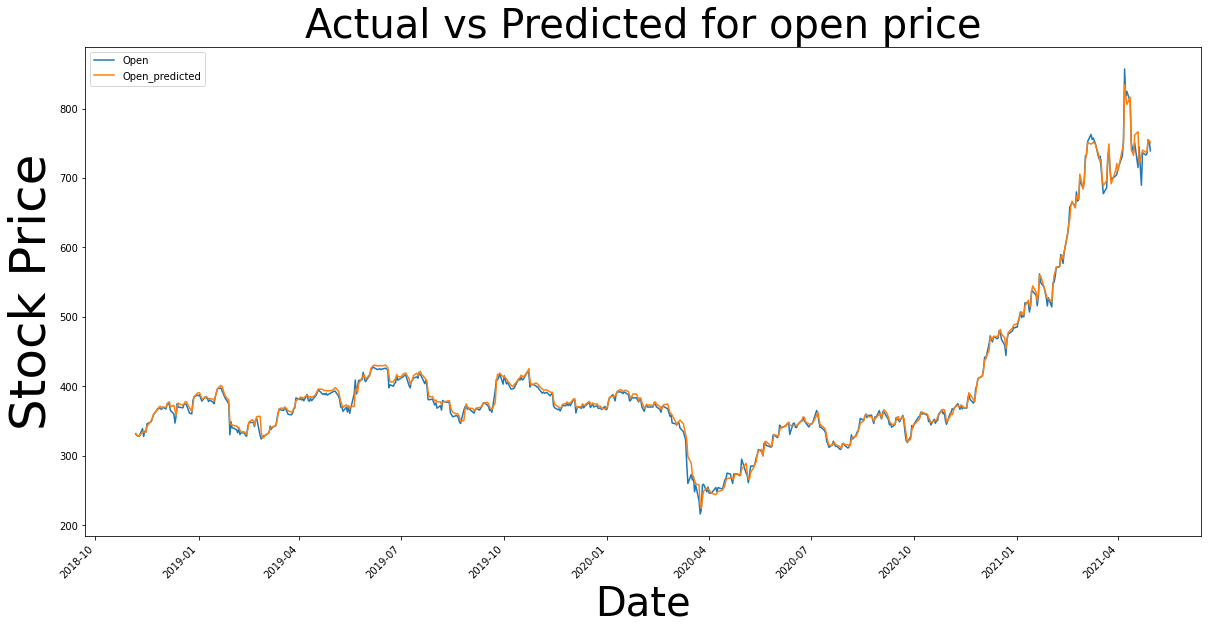

In [30]:
gs_slic_data[['Open','Open_predicted']].plot(figsize=(20,10))
plt.xticks(rotation=45)
plt.xlabel('Date',size=40)
plt.ylabel('Stock Price',size=50)
plt.title('Actual vs Predicted for open price',size=40)
plt.show()

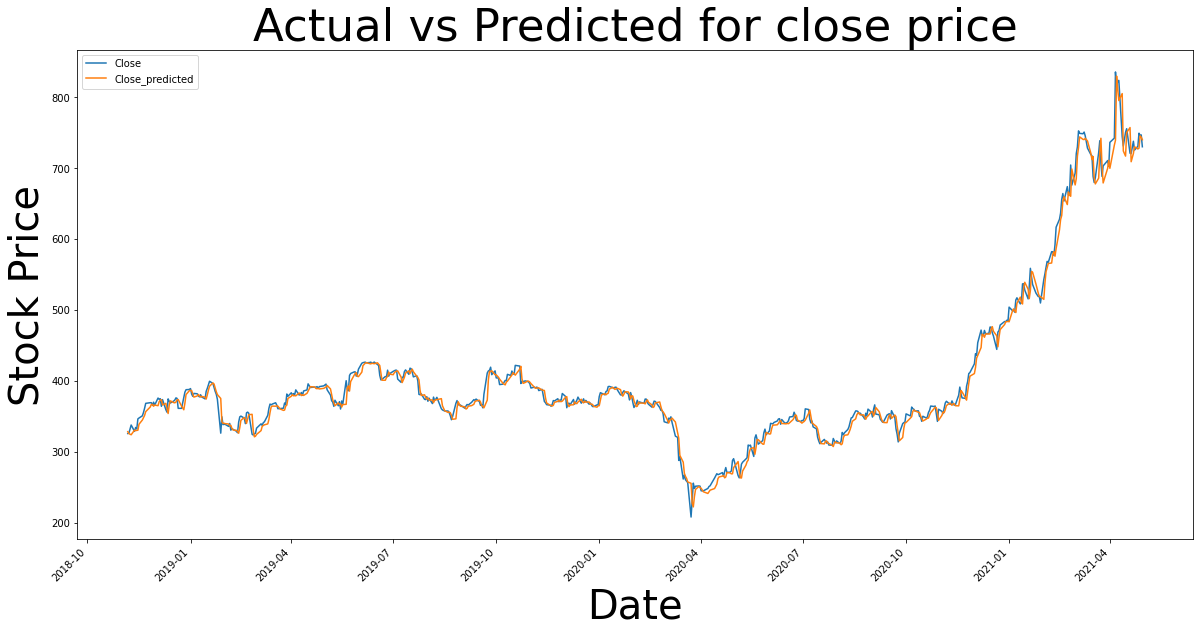

In [29]:
gs_slic_data[['Close','Close_predicted']].plot(figsize=(20,10))
plt.xticks(rotation=45)
plt.xlabel('Date',size=40)
plt.ylabel('Stock Price',size=40)
plt.title('Actual vs Predicted for close price',size=45)
plt.show()

In [31]:
# Creating a dataframe and adding 10 days to existing index 

gs_slic_data = gs_slic_data.append(pd.DataFrame(columns=gs_slic_data.columns,index=pd.date_range(start=gs_slic_data.index[-1], periods=11, freq='D', closed='right')))

In [32]:
gs_slic_data['2021-04-01	':'2021-05-10']

,Open,Close,Open_predicted,Close_predicted
2021-04-01,713.50,736.25,709.971863,699.657776
2021-04-05,731.75,742.25,741.203491,732.389221
2021-04-06,756.00,835.55,747.669189,739.112061
2021-04-07,857.00,814.75,834.234985,829.785461
2021-04-08,818.00,823.00,818.283142,811.564209
2021-04-09,824.75,823.60,805.789856,795.160828
2021-04-12,809.90,744.65,816.447998,805.028748
2021-04-13,750.00,731.05,740.315063,724.130554
2021-04-15,735.90,750.35,732.501953,716.869507
2021-04-16,750.90,755.50,761.608093,750.035217


In [33]:
upcoming_prediction = pd.DataFrame(columns=['Open','Close'],index=gs_slic_data.index)
upcoming_prediction.index=pd.to_datetime(upcoming_prediction.index)

In [34]:
curr_seq = test_seq[-1:]

for i in range(-10,0):
  up_pred = model.predict(curr_seq)
  upcoming_prediction.iloc[i] = up_pred
  curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
  curr_seq = curr_seq.reshape(test_seq[-1:].shape)

1/1 [==============================] - 0s 17ms/step


In [35]:
upcoming_prediction[['Open','Close']] = MMS.inverse_transform(upcoming_prediction[['Open','Close']])

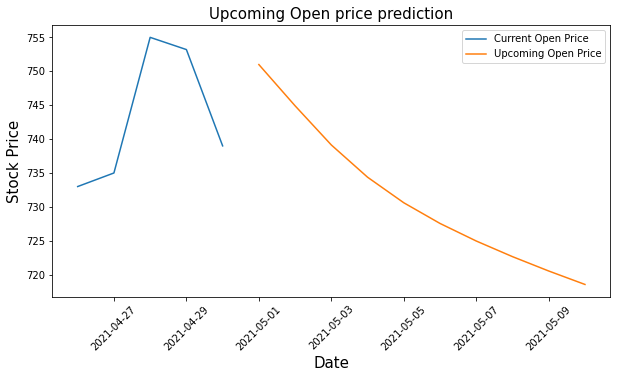

In [36]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-25':,'Open'],label='Current Open Price')
ax.plot(upcoming_prediction.loc['2021-04-25':,'Open'],label='Upcoming Open Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming Open price prediction',size=15)
ax.legend()
fg.show()

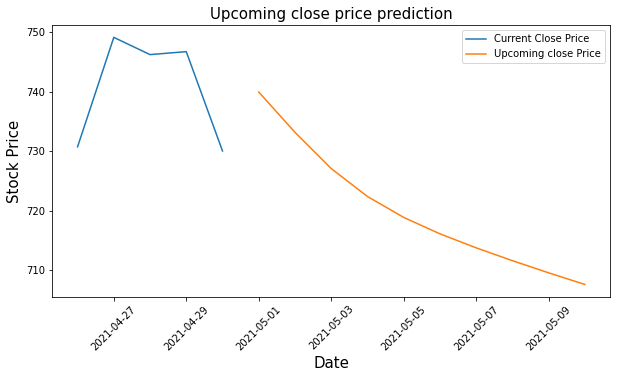

In [37]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-25':,'Close'],label='Current Close Price')
ax.plot(upcoming_prediction.loc['2021-04-25':,'Close'],label='Upcoming close Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming close price prediction',size=15)
ax.legend()
fg.show()